In [100]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
import glob
import random

# Learning Curves

## Data Loading

In [101]:
def load_all_scalars(events_file):
    ea = event_accumulator.EventAccumulator(events_file)
    ea.Reload()
    data = {}
    for tag in ea.Tags()['scalars']:
        df = pd.DataFrame(ea.Scalars(tag))
        data[tag] = df
    return data

In [102]:
log_dir = '../reported-runs/RQ2'

run_dirs = [os.path.join(log_dir, d) for d in os.listdir(log_dir) if not d.startswith('.')]

[print(p) for p in run_dirs]

../reported-runs/RQ2/Jun26_01-12-16_baseweather_epochs_250_pat_250_embed_32_wd_0.1_lr_1e-05_hgmm_32_lae_32_comp_30
../reported-runs/RQ2/Jun26_14-08-45_baseline_epochs_250_pat_250_embed_32_wd_0.1_lr_1e-05_hgmm_32_lae_32_comp_20


[None, None]

In [103]:
scalars_per_run = {}
for rd in run_dirs:
    
    rd_splt = rd.split('_')
    c_i = rd_splt.index('comp') + 1
    
    run_events_file = glob.glob(rd + '/events.out.tfevents.*')[0]
    scalars_per_run[int(rd_splt[c_i])] = load_all_scalars(run_events_file)

In [104]:
print(
    scalars_per_run.keys()
)

dict_keys([30, 20])


In [107]:
print(
    list(scalars_per_run[20].keys())
)

['Batch/te_loss', 'Batch/Energy', 'Batch/train_loss', 'Batch/Penalty', 'Epoch/train_loss', 'Epoch/validation_loss', 'Epoch/avg_energy', 'Epoch/avg_te_loss', 'Epoch/learning_rate', 'Epoch/true_loss']


In [110]:
scalars_per_run[30]['Epoch/validation_loss']

,wall_time,step,value
0,1.750893e+09,0,247.170807
1,1.750894e+09,1,241.689972
2,1.750894e+09,2,237.533585
3,1.750894e+09,3,234.042282
4,1.750894e+09,4,230.729675
...,...,...,...
245,1.750959e+09,245,89.485641
246,1.750959e+09,246,89.476166
247,1.750960e+09,247,89.517372
248,1.750960e+09,248,89.480507


## Restructure

In [111]:
keys_required = ['Epoch/train_loss', 
                 'Epoch/validation_loss', 
                 'Epoch/avg_energy', 
                 'Epoch/avg_te_loss', 
                 'Epoch/learning_rate',
                 'Epoch/true_loss']

In [112]:
dfs_c = []
for c in scalars_per_run.keys():
    run = scalars_per_run[c]
    
    for k in keys_required:
        scalar_df = run[k]
        scalar_df['scalar'] = k
        scalar_df['components'] = c
        dfs_c.append(scalar_df)
    
data = pd.concat(dfs_c, axis=0)
data = data.rename({'step': 'epoch'}, axis=1)
data['epoch'] = data['epoch'] + 1

In [113]:
data.head()

,wall_time,epoch,value,scalar,components
0,1.750893e+09,1,251.858337,Epoch/train_loss,30
1,1.750894e+09,2,244.469986,Epoch/train_loss,30
2,1.750894e+09,3,239.700806,Epoch/train_loss,30
3,1.750894e+09,4,235.937500,Epoch/train_loss,30
4,1.750894e+09,5,232.539200,Epoch/train_loss,30


In [114]:
data.groupby(['components', 'scalar'])['epoch'].count()

components  scalar               
20          Epoch/avg_energy         250
            Epoch/avg_te_loss        250
            Epoch/learning_rate      250
            Epoch/train_loss         250
            Epoch/true_loss          250
            Epoch/validation_loss    250
30          Epoch/avg_energy         250
            Epoch/avg_te_loss        250
            Epoch/learning_rate      250
            Epoch/train_loss         250
            Epoch/true_loss          250
            Epoch/validation_loss    250
Name: epoch, dtype: int64

In [115]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 249
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wall_time   3000 non-null   float64
 1   epoch       3000 non-null   int64  
 2   value       3000 non-null   float64
 3   scalar      3000 non-null   object 
 4   components  3000 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 140.6+ KB
None


In [116]:
print(
    data['scalar'].unique(),
    data['components'].unique(),
    sep='\n'
)

['Epoch/train_loss' 'Epoch/validation_loss' 'Epoch/avg_energy'
 'Epoch/avg_te_loss' 'Epoch/learning_rate' 'Epoch/true_loss']
[30 20]


## Plotting

### Methods

In [121]:
def plot_loss_by_components(
    data,
    title="Validation Loss and True Loss by Components",
    x_label="Epoch",
    y_label="Loss",
    figsize=(12, 8),
    colors=None,
    linestyles=None,
    linewidth=2,
    alpha=0.8,
    grid=True,
    log_scale=False,
    xlims=None,
    ylims=None,
    save_path=None,
    dpi=300,
    # New legend parameters
    legend_labels=None,
    legend_prefix="Components",
    show_loss_type_in_legend=False,
    legend_location='upper right',
    legend_fontsize=None,
    legend_ncol=1,
    legend_frameon=False,
    legend_fancybox=True,
    legend_shadow=True,
    legend_alpha=None
):

    # Filter data for validation_loss and true_loss
    loss_data = data[data['scalar'].isin(['Epoch/validation_loss', 'Epoch/true_loss'])].copy()
    
    # Clean scalar names for legend
    loss_data['loss_type'] = loss_data['scalar'].str.replace('Epoch/', '')
    
    # Get unique components and sort them
    components = sorted(loss_data['components'].unique())
    
    # Set default colors if not provided
    if colors is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(components)))
    elif len(colors) < len(components):
        # Extend colors if not enough provided
        colors = (colors * ((len(components) // len(colors)) + 1))[:len(components)]
    
    # Set default linestyles if not provided
    if linestyles is None:
        linestyles = {
            'validation_loss': '-',
            'true_loss': '--'
        }
    
    # Process legend labels
    def get_legend_label(component, loss_type=None):
        if legend_labels is None:
            base_label = f'{legend_prefix} {component}'
        elif isinstance(legend_labels, dict):
            base_label = legend_labels.get(component, f'{legend_prefix} {component}')
        elif isinstance(legend_labels, list):
            try:
                idx = components.index(component)
                base_label = legend_labels[idx]
            except (IndexError, ValueError):
                base_label = f'{legend_prefix} {component}'
        else:
            base_label = f'{legend_prefix} {component}'
        
        if show_loss_type_in_legend and loss_type:
            return f'{base_label} ({loss_type.replace("_", " ").title()})'
        return base_label
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Track legend entries
    legend_handles = []
    legend_labels_list = []
    
    # Plot for each component
    for i, component in enumerate(components):
        component_data = loss_data[loss_data['components'] == component]
        color = colors[i]
        
        # Plot validation loss and true loss for this component
        for loss_type in ['validation_loss', 'true_loss']:
            type_data = component_data[component_data['loss_type'] == loss_type]
            
            if not type_data.empty:
                # Sort by epoch for proper line plotting
                type_data = type_data.sort_values('epoch')
                
                linestyle = linestyles.get(loss_type, '-')
                
                line, = ax.plot(
                    type_data['epoch'], 
                    type_data['value'],
                    color=color,
                    linestyle=linestyle,
                    linewidth=linewidth,
                    alpha=alpha
                )
                
                # Add to legend based on settings
                if show_loss_type_in_legend:
                    # Add separate entries for each loss type
                    legend_handles.append(line)
                    legend_labels_list.append(get_legend_label(component, loss_type))
                elif loss_type == 'validation_loss':
                    # Only add validation_loss to legend (default behavior)
                    legend_handles.append(line)
                    legend_labels_list.append(get_legend_label(component))
    
    # Customize plot
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    if grid:
        ax.grid(True, alpha=0.3)

    if log_scale:
        ax.set_yscale('log')
    
    # Set axis limits if provided
    if xlims is not None:
        ax.set_xlim(xlims)
    
    if ylims is not None:
        ax.set_ylim(ylims)
    
    # Add legend with custom parameters
    if legend_handles:
        legend_kwargs = {
            'loc': legend_location,
            'frameon': legend_frameon,
            'fancybox': legend_fancybox,
            'shadow': legend_shadow,
            'ncol': legend_ncol
        }
        
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
        
        if legend_alpha is not None:
            legend_kwargs['framealpha'] = legend_alpha
        
        ax.legend(legend_handles, legend_labels_list, **legend_kwargs)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig, ax

### Create plots

#### RQ1

In [41]:
data_selected = data
data_selected = data[data['value'] > 0]

Figure saved to: plots/ecomponents_lc_full.pdf


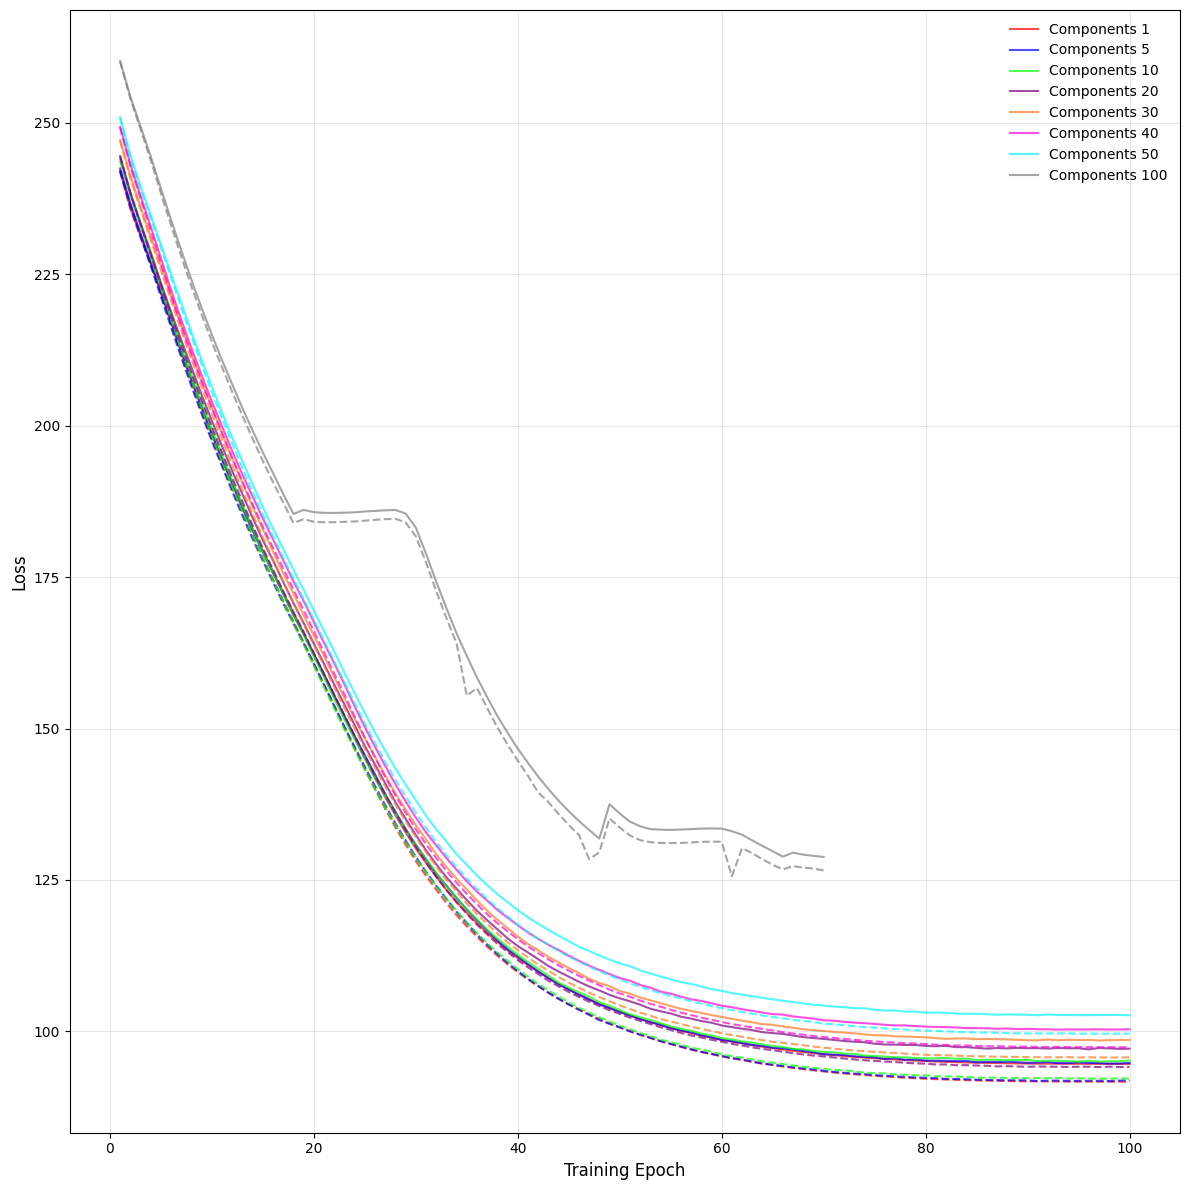

In [27]:
colors = ['red',  # 
         'green',
          '#f032e6',
         'grey',
         'blue',  # 
         '#46f0f0', 
         'orange',  
         'purple'  
        ]

colors2 = [
            "#FF0000",
            "#0000FF",
            "#00FF00",
            "#800080",
            "#FF7A22",
            "#FF05D1",
            "#05F7FF",
            "#827E7E"
          ]

# random.shuffle(colors2)


fig, ax = plot_loss_by_components(
    data_selected,
    title=None,
    x_label="Training Epoch",
    y_label="Loss",
    legend_labels=['Baseline', 'Enhanced']
    figsize=(12, 12),
    colors=colors2,
    linestyles={'validation_loss': '-', 'true_loss': '--'},
    linewidth=1.5,
    alpha=0.7,
    grid=True,
    xlims=None,
    ylims=None,
    # save_path='plots/ecomponents_lc_full.pdf',
    dpi=None
)
plt.show()

In [18]:
data_selected2 = data_selected[data_selected['components'] != 100]

Figure saved to: plots/ecomponents_lc_zoomed.pdf


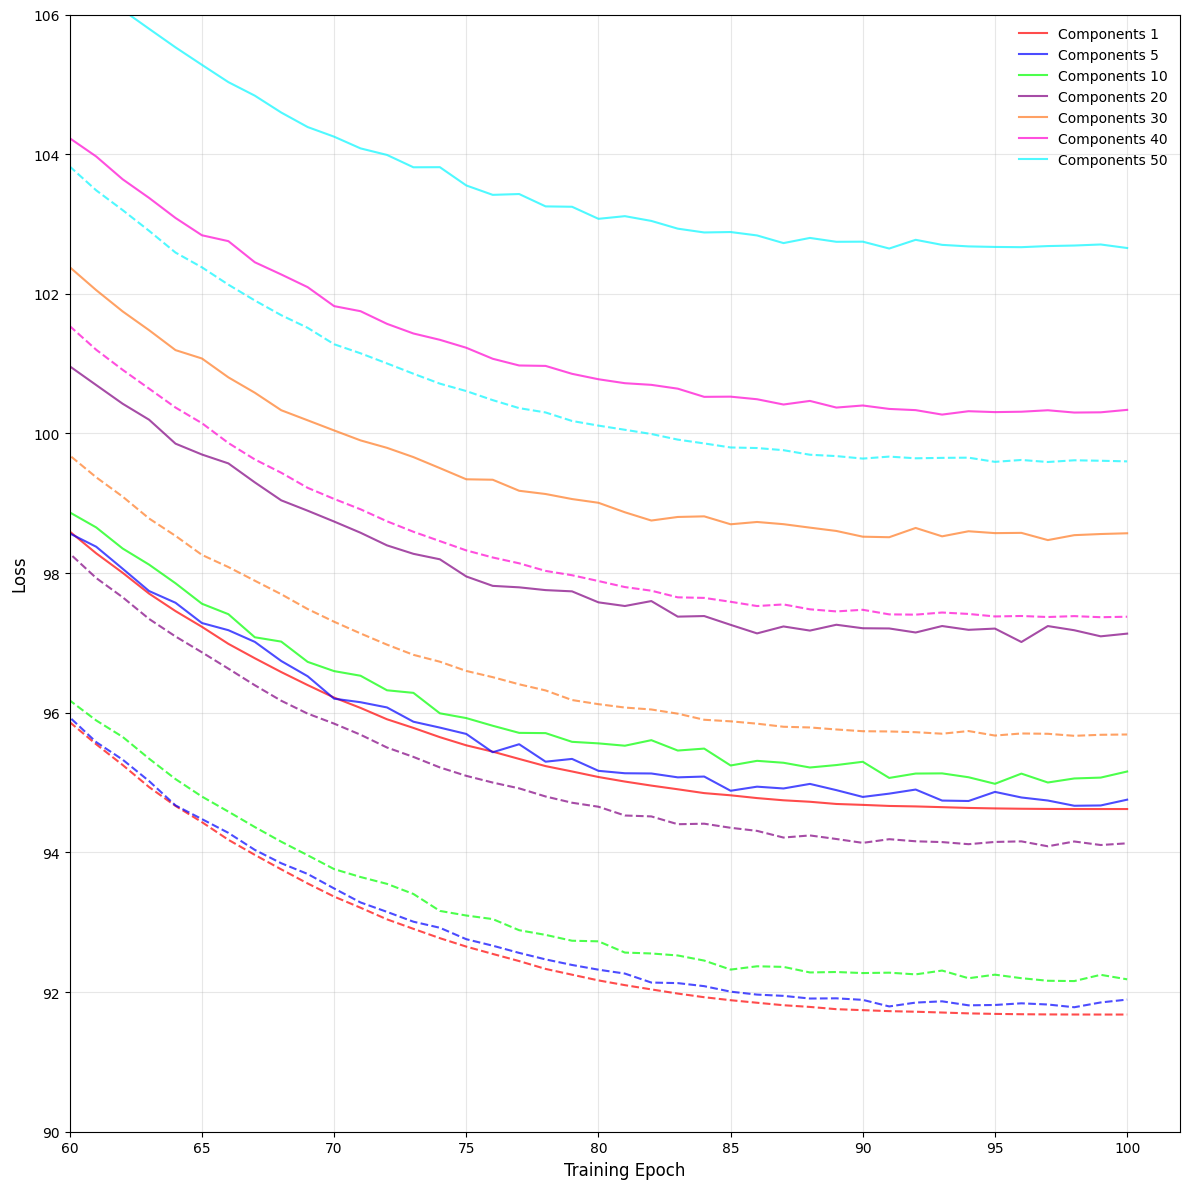

In [26]:
fig, ax = plot_loss_by_components(
    data_selected2,
    title=None,
    x_label="Training Epoch",
    y_label="Loss",
    figsize=(12, 12),
    colors=colors2,
    linestyles={'validation_loss': '-', 'true_loss': '--'},
    linewidth=1.5,
    alpha=0.7,
    grid=True,
    xlims=(60, 102),
    ylims=(90, 106),
    save_path='plots/ecomponents_lc_zoomed.pdf',
    dpi=None
)
plt.show()

#### RQ2

In [119]:
data_rq2 = data

Figure saved to: plots/RQ2/rq2-loss-curves.pdf


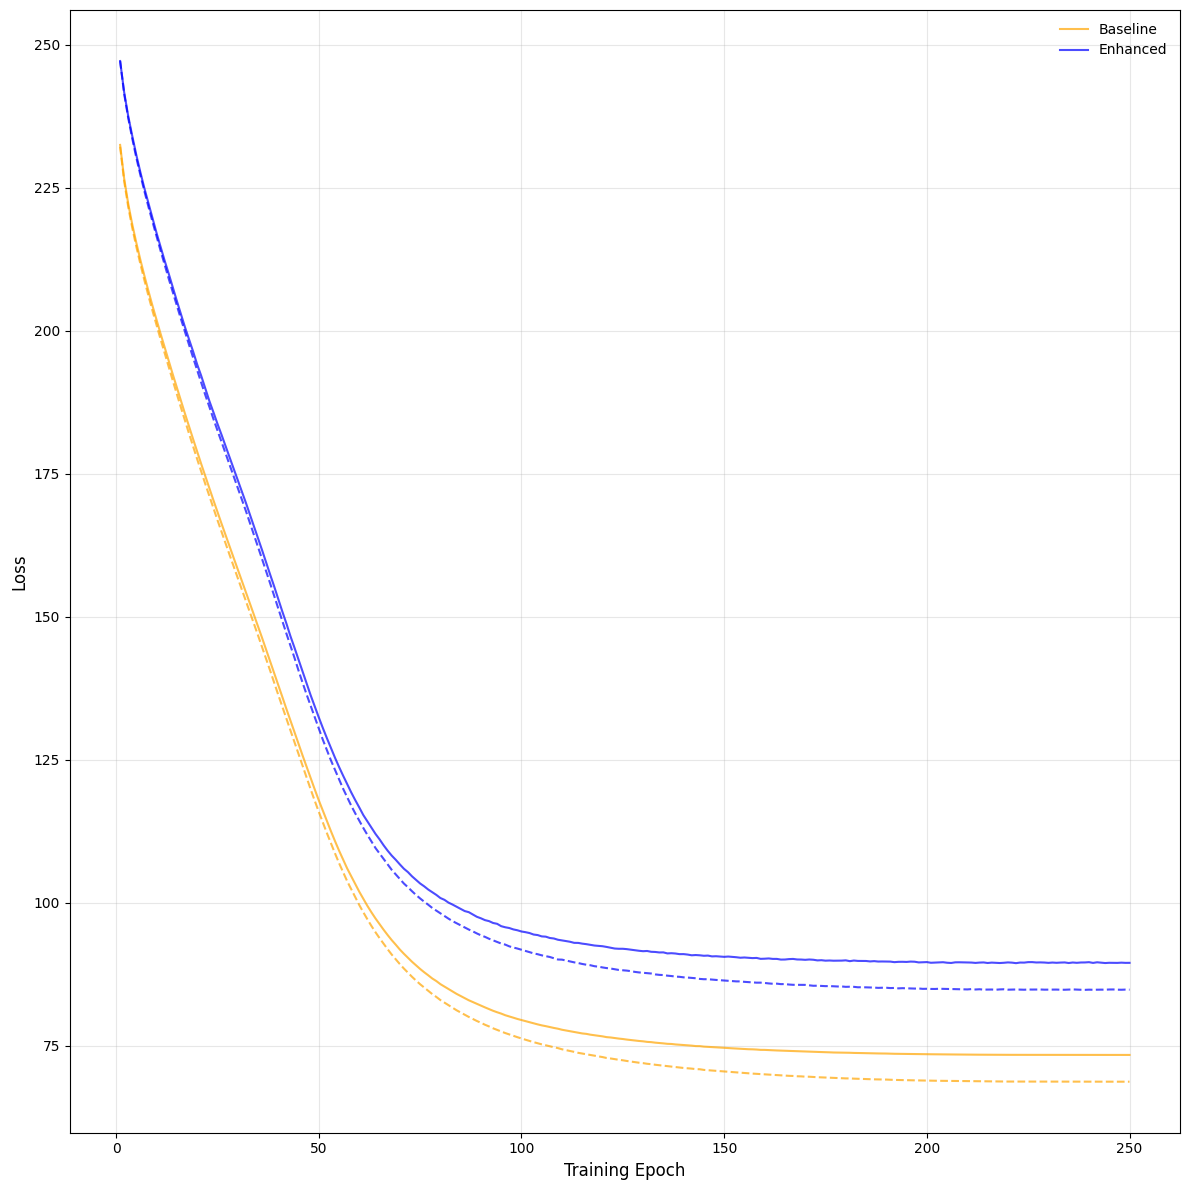

In [125]:
fig, ax = plot_loss_by_components(
    data_rq2,
    title=None,
    x_label="Training Epoch",
    y_label="Loss",
    legend_labels=['Baseline', 'Enhanced'],
    figsize=(12, 12),
    colors=['orange', 'blue'],
    linestyles={'validation_loss': '-', 'true_loss': '--'},
    linewidth=1.5,
    alpha=0.7,
    grid=True,
    xlims=None,
    ylims=None,
    save_path='plots/RQ2/rq2-loss-curves.pdf',
    dpi=None,
    show_loss_type_in_legend=False,
)
plt.show()

In [118]:
def plot_learning_curves(loss_df,
                        epoch_col='epoch',
                        loss_cols=['Epoch/train_loss', 'Epoch/validation_loss','Epoch/true_loss'],
                        labels=['Training Loss', 'Validation Loss', 'True Loss'],
                        title=None,
                        xlabel='Epoch',
                        ylabel='Loss',
                        figsize=(10, 6),
                        colors=None,
                        linestyles=None,
                        linewidth=2,
                        alpha=0.8,
                        grid=True,
                        save_path=None,
                        dpi=1200):
    """
    Create a professional learning curve plot.

    Parameters:
    -----------
    loss_df : pandas.DataFrame
        DataFrame containing epoch and loss data
    epoch_col : str
        Column name for epochs (default: 'Epoch')
    loss_cols : list
        List of column names for loss values. If None, uses all columns except epoch_col
    labels : list
        List of labels for the legend. If None, uses column names
    title : str
        Plot title
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    figsize : tuple
        Figure size (width, height)
    colors : list
        List of colors for each line. If None, uses default matplotlib colors
    linestyles : list
        List of line styles. If None, uses solid lines
    linewidth : float
        Line width
    alpha : float
        Line transparency
    grid : bool
        Whether to show grid
    save_path : str
        Path to save the figure. If None, doesn't save
    dpi : int
        DPI for saved figure

    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """

    # Set up the plot with professional styling
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=figsize)

    # Determine loss columns if not provided
    if loss_cols is None:
        loss_cols = [col for col in loss_df.columns if col != epoch_col]

    # Set default labels if not provided
    if labels is None:
        labels = loss_cols

    # Set default colors if not provided
    if colors is None:
        colors = plt.cm.Set1(np.linspace(0, 1, len(loss_cols)))

    # Set default line styles if not provided
    if linestyles is None:
        linestyles = ['-'] * len(loss_cols)

    # Plot each loss curve
    for i, (loss_col, label, color, linestyle) in enumerate(zip(loss_cols, labels, colors, linestyles)):
        ax.plot(loss_df[epoch_col],
                loss_df[loss_col],
                label=label,
                color=color,
                linestyle=linestyle,
                linewidth=linewidth,
                alpha=alpha)

    # Customize the plot
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    if title:
        ax.set_title(title, fontsize=14, pad=20)

    # Add grid
    if grid:
        ax.grid(True, alpha=0.3, linestyle='--')

    # Customize legend
    ax.legend(frameon=True, fancybox=True, shadow=True,
              loc='upper right', fontsize=10)

    # Set spine colors and remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')

    # Improve tick appearance
    ax.tick_params(colors='gray', which='both')

    # Tight layout
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight',
                   facecolor='white', edgecolor='black')

    return fig, ax

In [ ]:
plot_learning_curves()